# Training the perturbed GCN and getting counterfactual explanations

In [1]:
# first import the needed packages
import pickle
import torch
import numpy as np
from statistics import mean
from gcn import *
from gcn_perturbation_matrix import *
from sklearn.metrics import accuracy_score
from explainer_framework import *
from calculate_metrics import *
from models_original_paper.gcn import GCNSynthetic as GCN_original

/Users/janneke/opt/anaconda3/envs/CF-GNNExplainer/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read in the data we are working with:

In [2]:
with open('data/syn1.pickle','rb') as pickle_file: 
    data_syn1 = pickle.load(pickle_file)

with open('data/syn4.pickle','rb') as pickle_file:
    data_syn4 = pickle.load(pickle_file)
    
with open('data/syn5.pickle','rb') as pickle_file:
    data_syn5 = pickle.load(pickle_file)

## Transform the data into tensors, format everything properly:

In [3]:
# squeeze the labels (as it has a singleton dim and then make it a tensor)
labels_syn1 = np.squeeze(data_syn1['labels'])
labels_syn1 = torch.tensor(labels_syn1)

labels_syn4 = np.squeeze(data_syn4['labels'])
labels_syn4 = torch.tensor(labels_syn4)

labels_syn5 = np.squeeze(data_syn5['labels'])
labels_syn5 = torch.tensor(labels_syn5)

# same for features, but define the type of data here
features_syn1 = np.squeeze(data_syn1['feat'])
features_syn1 = torch.tensor(features_syn1, dtype=torch.float)

features_syn4 = np.squeeze(data_syn4['feat'])
features_syn4 = torch.tensor(features_syn4, dtype=torch.float)

features_syn5 = np.squeeze(data_syn5['feat'])
features_syn5 = torch.tensor(features_syn5, dtype=torch.float)

# adjacency matrix
adjacency_matrix_syn1 = torch.tensor(np.squeeze(data_syn1['adj']), dtype=torch.float)
adjacency_matrix_syn4 = torch.tensor(np.squeeze(data_syn4['adj']), dtype=torch.float)
adjacency_matrix_syn5 = torch.tensor(np.squeeze(data_syn5['adj']), dtype=torch.float)

test_indices_syn1 = torch.tensor(data_syn1['test_idx'])
test_indices_syn4 = torch.tensor(data_syn4['test_idx'])
test_indices_syn5 = torch.tensor(data_syn5['test_idx'])

# Get the adjacency matrices normalized, and in sparse format (needed for the GCN message passing)
sparse_adj_1 = get_sparse_adjacency_normalized(features_syn1.shape[0], adjacency_matrix_syn1)
sparse_adj_4 = get_sparse_adjacency_normalized(features_syn4.shape[0], adjacency_matrix_syn4)
sparse_adj_5 = get_sparse_adjacency_normalized(features_syn5.shape[0], adjacency_matrix_syn5)

/Users/janneke/Documents/GitHub/CF-GNNExplainer-recreation/gcn.py:159: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525473998/work/torch/csrc/utils/tensor_new.cpp:233.)
  A_hat = torch.sparse_coo_tensor((A_hat.row, A_hat.col), A_hat.data, dtype=torch.float)


## Part 1: explanation framework with the original GCN (from the original paper)
We do this to isolate the explanation framework from the GCN as a test -- so we can discover later on what the differences are between the output of the model, and of how the framework tries to explain this.

### Get the original model

In [4]:
model_syn1_dict_orig = torch.load('models_original_paper/gcn_3layer_syn1.pt')
model_syn4_dict_orig = torch.load('models_original_paper/gcn_3layer_syn4.pt')
model_syn5_dict_orig = torch.load('models_original_paper/gcn_3layer_syn5.pt')

# load the models, using the state dictionary
# note that GCN_original is the model that was used in the CF-GNNExplainer paper
model_syn1_orig = GCN_original(nfeat=model_syn1_dict_orig['gc1.weight'].shape[0], nhid=model_syn1_dict_orig['gc1.weight'].shape[1], nout=model_syn1_dict_orig['gc1.weight'].shape[1], nclass=model_syn1_dict_orig['lin.bias'].shape[0], dropout=0)
model_syn1_orig.load_state_dict(model_syn1_dict_orig)

model_syn4_orig = GCN_original(nfeat=model_syn4_dict_orig['gc1.weight'].shape[0], nhid=model_syn4_dict_orig['gc1.weight'].shape[1], nout=model_syn4_dict_orig['gc1.weight'].shape[1], nclass=model_syn4_dict_orig['lin.bias'].shape[0], dropout=0)
model_syn4_orig.load_state_dict(model_syn4_dict_orig)

model_syn5_orig = GCN_original(nfeat=model_syn5_dict_orig['gc1.weight'].shape[0], nhid=model_syn5_dict_orig['gc1.weight'].shape[1], nout=model_syn5_dict_orig['gc1.weight'].shape[1], nclass=model_syn5_dict_orig['lin.bias'].shape[0], dropout=0)
model_syn5_orig.load_state_dict(model_syn5_dict_orig)

<All keys matched successfully>

### Get the original predictions

In [5]:
# evaluate the models --> get the predictions of all the nodes
model_syn1_orig.eval()
outputs_syn1_orig = model_syn1_orig(features_syn1, sparse_adj_1)
_, predictions_1_orig = torch.max(outputs_syn1_orig.data, 1)
print("Test accuracy of Syn1 data: ", accuracy_score(labels_syn1[test_indices_syn1], predictions_1_orig[test_indices_syn1]))

model_syn4_orig.eval()
outputs_syn4_orig = model_syn4_orig(features_syn4, sparse_adj_4)
_, predictions_4_orig = torch.max(outputs_syn4_orig.data, 1)
print("Test accuracy of Syn4 data: ", accuracy_score(labels_syn4[test_indices_syn4], predictions_4_orig[test_indices_syn4]))

model_syn5_orig.eval()
outputs_syn5_orig = model_syn5_orig(features_syn5, sparse_adj_5)
_, predictions_5_orig = torch.max(outputs_syn5_orig.data, 1)
print("Test accuracy of Syn5 data: ", accuracy_score(labels_syn5[test_indices_syn5], predictions_5_orig[test_indices_syn5]))

Test accuracy of Syn1 data:  0.9857142857142858
Test accuracy of Syn4 data:  0.9085714285714286
Test accuracy of Syn5 data:  0.8744939271255061


### Put the weights in the correct dictionaries

In [6]:
# put the weights in dictionaries that the find-explanations-function can use later on to create a perturbed GNN
model_weights_original_syn1 = dict()
model_weights_original_syn1["layer1_W"] = model_syn1_dict_orig['gc1.weight'].detach()
model_weights_original_syn1["layer1_b"] = model_syn1_dict_orig['gc1.bias'].detach()
model_weights_original_syn1["layer2_W"] = model_syn1_dict_orig['gc2.weight'].detach()
model_weights_original_syn1["layer2_b"] = model_syn1_dict_orig['gc2.bias'].detach()
model_weights_original_syn1["layer3_W"] = model_syn1_dict_orig['gc3.weight'].detach()
model_weights_original_syn1["layer3_b"] = model_syn1_dict_orig['gc3.bias'].detach()
model_weights_original_syn1["lin_weight"] = model_syn1_dict_orig['lin.weight'].detach()
model_weights_original_syn1["lin_b"] = model_syn1_dict_orig['lin.bias'].detach()

model_weights_original_syn4 = dict()
model_weights_original_syn4["layer1_W"] = model_syn4_dict_orig['gc1.weight'].detach()
model_weights_original_syn4["layer1_b"] = model_syn4_dict_orig['gc1.bias'].detach()
model_weights_original_syn4["layer2_W"] = model_syn4_dict_orig['gc2.weight'].detach()
model_weights_original_syn4["layer2_b"] = model_syn4_dict_orig['gc2.bias'].detach()
model_weights_original_syn4["layer3_W"] = model_syn4_dict_orig['gc3.weight'].detach()
model_weights_original_syn4["layer3_b"] = model_syn4_dict_orig['gc3.bias'].detach()
model_weights_original_syn4["lin_weight"] = model_syn4_dict_orig['lin.weight'].detach()
model_weights_original_syn4["lin_b"] = model_syn4_dict_orig['lin.bias'].detach()

model_weights_original_syn5 = dict()
model_weights_original_syn5["layer1_W"] = model_syn5_dict_orig['gc1.weight'].detach()
model_weights_original_syn5["layer1_b"] = model_syn5_dict_orig['gc1.bias'].detach()
model_weights_original_syn5["layer2_W"] = model_syn5_dict_orig['gc2.weight'].detach()
model_weights_original_syn5["layer2_b"] = model_syn5_dict_orig['gc2.bias'].detach()
model_weights_original_syn5["layer3_W"] = model_syn5_dict_orig['gc3.weight'].detach()
model_weights_original_syn5["layer3_b"] = model_syn5_dict_orig['gc3.bias'].detach()
model_weights_original_syn5["lin_weight"] = model_syn5_dict_orig['lin.weight'].detach()
model_weights_original_syn5["lin_b"] = model_syn5_dict_orig['lin.bias'].detach()

### Use the CF-GNNExplainer to find the counterfactual explanations and metrics

In [7]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# hyperparameters
alpha_orig_syn1 = 0.1
beta_orig_syn1 = 0.5
momentum_orig_syn1 = 0.9
nr_iterations_orig_syn1 = 500

# get counterfactual examples
counterfactual_examples_syn1_orig, adjacency_neighbourhoods_syn1_orig, mapping_vertices_syn1_orig, number_counterfactual_examples_syn1_orig = find_counterfactual_explanations(test_indices_syn1, model_syn1_orig, predictions_1_orig, labels_syn1, features_syn1, adjacency_matrix_syn1, 
                                                                                                                                                    model_weights_original_syn1, alpha_orig_syn1, beta_orig_syn1, momentum_orig_syn1, 3, nr_iterations_orig_syn1)

sparsity_mean_orig_syn1, sparsity_std_orig_syn1 = sparsity(adjacency_neighbourhoods_syn1_orig, counterfactual_examples_syn1_orig)
fidelity_orig_syn1 = fidelity(len(test_indices_syn1), number_counterfactual_examples_syn1_orig)
accuracy_edge_mean_orig_syn1, accuracy_edge_std_orig_syn1, accuracy_vertices_mean_orig_syn1, accuracy_vertices_std_orig_syn1  = accuracy_explanation(test_indices_syn1, predictions_1_orig, adjacency_neighbourhoods_syn1_orig, counterfactual_examples_syn1_orig, mapping_vertices_syn1_orig)
explanation_size_mean_orig_syn1, explanation_size_std_orig_syn1, explanation_size_list_orig_syn1 = explanation_size(counterfactual_examples_syn1_orig, adjacency_neighbourhoods_syn1_orig)

print("Syn1, mean sparsity:", sparsity_mean_orig_syn1)
print("Syn1, fidelity:", fidelity_orig_syn1)
print("Syn1, mean accuracy (edges):", accuracy_edge_mean_orig_syn1)
print("Syn1, mean accuracy (vertices):", accuracy_vertices_mean_orig_syn1)
print("Syn1, mean explanation size:", explanation_size_mean_orig_syn1)
print()
print("Syn1, std sparsity:", sparsity_std_orig_syn1)
print("Syn1, std accuracy (edges):", accuracy_edge_std_orig_syn1)
print("Syn1, std accuracy (vertices):", accuracy_vertices_std_orig_syn1)
print("Syn1, std explanation size:", explanation_size_std_orig_syn1)

/Users/janneke/Documents/GitHub/CF-GNNExplainer-recreation/gcn_perturbation_matrix.py:187: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nll_loss_part = nll_loss(F.log_softmax(output_g), target=prediction_original)


Syn1, mean sparsity: 0.9880629164070579
Syn1, fidelity: 0.1785714285714286
Syn1, mean accuracy (edges): 0.9935897435897436
Syn1, mean accuracy (vertices): 0.9967948717948718
Syn1, mean explanation size: 2.0869565217391304

Syn1, std sparsity: 0.0216379374997368
Syn1, std accuracy (edges): 0.05661385170722979
Syn1, std accuracy (vertices): 0.028306925853614894
Syn1, std explanation size: 2.230432329232618


In [8]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# hyperparameters
alpha_orig_syn4 = 0.1
beta_orig_syn4 = 0.5
momentum_orig_syn4 = 0
nr_iterations_orig_syn4 = 500

# get counterfactual examples
counterfactual_examples_syn4_orig, adjacency_neighbourhoods_syn4_orig, mapping_vertices_syn4_orig, number_counterfactual_examples_syn4_orig = find_counterfactual_explanations(test_indices_syn4, model_syn4_orig, predictions_4_orig, labels_syn4, features_syn4, adjacency_matrix_syn4, 
                                                                                                                                                    model_weights_original_syn4, alpha_orig_syn4, beta_orig_syn4, momentum_orig_syn4, 3, nr_iterations_orig_syn4)

sparsity_mean_orig_syn4, sparsity_std_orig_syn4 = sparsity(adjacency_neighbourhoods_syn4_orig, counterfactual_examples_syn4_orig)
fidelity_orig_syn4 = fidelity(len(test_indices_syn4), number_counterfactual_examples_syn4_orig)
accuracy_edge_mean_orig_syn4, accuracy_edge_std_orig_syn4, accuracy_vertices_mean_orig_syn4, accuracy_vertices_std_orig_syn4 = accuracy_explanation(test_indices_syn4, predictions_4_orig, adjacency_neighbourhoods_syn4_orig, counterfactual_examples_syn4_orig, mapping_vertices_syn4_orig)
explanation_size_mean_orig_syn4, explanation_size_std_orig_syn4, explanation_size_list_orig_syn4 = explanation_size(counterfactual_examples_syn4_orig, adjacency_neighbourhoods_syn4_orig)

print("Syn4, mean sparsity:", sparsity_mean_orig_syn4)
print("Syn4, fidelity:", fidelity_orig_syn4)
print("Syn4, mean accuracy (edges):", accuracy_edge_mean_orig_syn4)
print("Syn4, mean accuracy (vertices):", accuracy_vertices_mean_orig_syn4)
print("Syn4, mean explanation size:", explanation_size_mean_orig_syn4)
print()
print("Syn4, std sparsity:", sparsity_std_orig_syn4)
print("Syn4, std accuracy (edges):", accuracy_edge_std_orig_syn4)
print("Syn4, std accuracy (vertices):", accuracy_vertices_std_orig_syn4)
print("Syn4, std explanation size:", explanation_size_std_orig_syn4)

Syn4, mean sparsity: 0.916360701158129
Syn4, fidelity: 0.17142857142857137
Syn4, mean accuracy (edges): 0.9509803921568627
Syn4, mean accuracy (vertices): 0.9722222222222222
Syn4, mean explanation size: 1.5655172413793104

Syn4, std sparsity: 0.04909336212398611
Syn4, std accuracy (edges): 0.20627413703090153
Syn4, std accuracy (vertices): 0.11979921473804346
Syn4, std explanation size: 1.1535801343802612


In [26]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# hyperparameters
alpha_orig_syn5 = 0.1
beta_orig_syn5 = 0.5
momentum_orig_syn5 = 0
nr_iterations_orig_syn5 = 500

# get counterfactual examples
counterfactual_examples_syn5_orig, adjacency_neighbourhoods_syn5_orig, mapping_vertices_syn5_orig, number_counterfactual_examples_syn5_orig = find_counterfactual_explanations(test_indices_syn5, model_syn5_orig, predictions_5_orig, labels_syn5, features_syn5, adjacency_matrix_syn5, 
                                                                                                                                                    model_weights_original_syn5, alpha_orig_syn5, beta_orig_syn5, momentum_orig_syn5, 3, nr_iterations_orig_syn5)

sparsity_mean_orig_syn5, sparsity_std_orig_syn5 = sparsity(adjacency_neighbourhoods_syn5_orig, counterfactual_examples_syn5_orig)
fidelity_orig_syn5 = fidelity(len(test_indices_syn5), number_counterfactual_examples_syn5_orig)
accuracy_edge_mean_orig_syn5, accuracy_edge_std_orig_syn5, accuracy_vertices_mean_orig_syn5, accuracy_vertices_std_orig_syn5 = accuracy_explanation(test_indices_syn5, predictions_5_orig, adjacency_neighbourhoods_syn5_orig, counterfactual_examples_syn5_orig, mapping_vertices_syn5_orig)
explanation_size_mean_orig_syn5, explanation_size_std_orig_syn5, explanation_size_list_orig_syn5 = explanation_size(counterfactual_examples_syn5_orig, adjacency_neighbourhoods_syn5_orig)

print("Syn5, mean sparsity:", sparsity_mean_orig_syn5)
print("Syn5, fidelity:", fidelity_orig_syn5)
print("Syn5, mean accuracy (edges):", accuracy_edge_mean_orig_syn5)
print("Syn4, mean accuracy (vertices):", accuracy_vertices_mean_orig_syn5)
print("Syn5, mean explanation size:", explanation_size_mean_orig_syn5)
print()
print("Syn5, std sparsity:", sparsity_std_orig_syn5)
print("Syn5, std accuracy (edges):", accuracy_edge_std_orig_syn5)
print("Syn4, std accuracy (vertices):", accuracy_vertices_std_orig_syn5)
print("Syn5, std explanation size:", explanation_size_std_orig_syn5)

/Users/janneke/Documents/GitHub/CF-GNNExplainer-recreation/gcn_perturbation_matrix.py:187: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nll_loss_part = nll_loss(F.log_softmax(output_g), target=prediction_original)


Syn5, mean sparsity: 0.9469845265236888
Syn5, fidelity: 0.04453441295546556
Syn5, mean accuracy (edges): 0.9113475177304965
Syn4, mean accuracy (vertices): 0.9408983451536643
Syn5, mean explanation size: 1.3305084745762712

Syn5, std sparsity: 0.04171070244423978
Syn5, std accuracy (edges): 0.28210742598762933
Syn4, std accuracy (vertices): 0.2003318197520764
Syn5, std explanation size: 0.7211702634357896


## Part 2: Explanation framework with my own GCN:

### Get the original models

In [10]:
model_syn1_mine = torch.load('models/syn1model.pt')
model_syn4_mine = torch.load('models/syn4model.pt')
model_syn5_mine = torch.load('models/syn5model.pt')

### Get the original predictions

In [11]:
model_syn1_mine.eval()
outputs_syn1_mine = model_syn1_mine(features_syn1, sparse_adj_1)
_, predictions_1_mine = torch.max(outputs_syn1_mine.data, 1)
print("Test accuracy of Syn1 data: ", accuracy_score(labels_syn1[test_indices_syn1], predictions_1_mine[test_indices_syn1]))

model_syn4_mine.eval()
outputs_syn4_mine = model_syn4_mine(features_syn4, sparse_adj_4)
_, predictions_4_mine = torch.max(outputs_syn4_mine.data, 1)
print("Test accuracy of Syn4 data: ", accuracy_score(labels_syn4[test_indices_syn4], predictions_4_mine[test_indices_syn4]))

model_syn5_mine.eval()
outputs_syn5_mine = model_syn5_mine(features_syn5, sparse_adj_5)
_, predictions_5_mine = torch.max(outputs_syn5_mine.data, 1)
print("Test accuracy of Syn5 data: ", accuracy_score(labels_syn5[test_indices_syn5], predictions_5_mine[test_indices_syn5]))

Test accuracy of Syn1 data:  0.9928571428571429
Test accuracy of Syn4 data:  0.9142857142857143
Test accuracy of Syn5 data:  0.8623481781376519


### Put the weights in the right dictionaries

In [12]:
model_weights_mine_syn1 = dict()
model_weights_mine_syn1["layer1_W"] = model_syn1_mine.gcn_layer_1.W.detach()
model_weights_mine_syn1["layer1_b"] = model_syn1_mine.gcn_layer_1.b.detach()
model_weights_mine_syn1["layer2_W"] = model_syn1_mine.gcn_layer_2.W.detach()
model_weights_mine_syn1["layer2_b"] = model_syn1_mine.gcn_layer_2.b.detach()
model_weights_mine_syn1["layer3_W"] = model_syn1_mine.gcn_layer_3.W.detach()
model_weights_mine_syn1["layer3_b"] = model_syn1_mine.gcn_layer_3.b.detach()
model_weights_mine_syn1["lin_weight"] = model_syn1_mine.linear_layer.weight.detach()
model_weights_mine_syn1["lin_b"] = model_syn1_mine.linear_layer.bias.detach()

model_weights_mine_syn4 = dict()
model_weights_mine_syn4["layer1_W"] = model_syn4_mine.gcn_layer_1.W.detach()
model_weights_mine_syn4["layer1_b"] = model_syn4_mine.gcn_layer_1.b.detach()
model_weights_mine_syn4["layer2_W"] = model_syn4_mine.gcn_layer_2.W.detach()
model_weights_mine_syn4["layer2_b"] = model_syn4_mine.gcn_layer_2.b.detach()
model_weights_mine_syn4["layer3_W"] = model_syn4_mine.gcn_layer_3.W.detach()
model_weights_mine_syn4["layer3_b"] = model_syn4_mine.gcn_layer_3.b.detach()
model_weights_mine_syn4["lin_weight"] = model_syn4_mine.linear_layer.weight.detach()
model_weights_mine_syn4["lin_b"] = model_syn4_mine.linear_layer.bias.detach()

model_weights_mine_syn5 = dict()
model_weights_mine_syn5["layer1_W"] = model_syn5_mine.gcn_layer_1.W.detach()
model_weights_mine_syn5["layer1_b"] = model_syn5_mine.gcn_layer_1.b.detach()
model_weights_mine_syn5["layer2_W"] = model_syn5_mine.gcn_layer_2.W.detach()
model_weights_mine_syn5["layer2_b"] = model_syn5_mine.gcn_layer_2.b.detach()
model_weights_mine_syn5["layer3_W"] = model_syn5_mine.gcn_layer_3.W.detach()
model_weights_mine_syn5["layer3_b"] = model_syn5_mine.gcn_layer_3.b.detach()
model_weights_mine_syn5["lin_weight"] = model_syn5_mine.linear_layer.weight.detach()
model_weights_mine_syn5["lin_b"] = model_syn5_mine.linear_layer.bias.detach()

### Find the CF-explanations and the metrics

In [14]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# hyperparameters
alpha_mine_syn1 = 0.1
beta_mine_syn1 = 0.5
momentum_mine_syn1 = 0.9
nr_iterations_mine_syn1 = 500

# get counterfactual examples
counterfactual_examples_syn1_mine, adjacency_neighbourhoods_syn1_mine, mapping_vertices_syn1_mine, number_counterfactual_examples_syn1_mine = find_counterfactual_explanations(test_indices_syn1, model_syn1_mine, predictions_1_mine, labels_syn1, features_syn1, adjacency_matrix_syn1, 
                                                                                                                                                    model_weights_mine_syn1, alpha_mine_syn1, beta_mine_syn1, momentum_mine_syn1, 3, nr_iterations_mine_syn1)

sparsity_mean_mine_syn1, sparsity_std_mine_syn1 = sparsity(adjacency_neighbourhoods_syn1_mine, counterfactual_examples_syn1_mine)
fidelity_mine_syn1 = fidelity(len(test_indices_syn1), number_counterfactual_examples_syn1_mine)
accuracy_edge_mean_mine_syn1, accuracy_edge_std_mine_syn1, accuracy_vertices_mean_mine_syn1, accuracy_vertices_std_mine_syn1  = accuracy_explanation(test_indices_syn1, predictions_1_mine, adjacency_neighbourhoods_syn1_mine, counterfactual_examples_syn1_mine, mapping_vertices_syn1_mine)
explanation_size_mean_mine_syn1, explanation_size_std_mine_syn1, explanation_size_list_mine_syn1 = explanation_size(counterfactual_examples_syn1_mine, adjacency_neighbourhoods_syn1_mine)

print("Syn1, mean sparsity:", sparsity_mean_mine_syn1)
print("Syn1, fidelity:", fidelity_mine_syn1)
print("Syn1, mean accuracy (edges):", accuracy_edge_mean_mine_syn1)
print("Syn4, mean accuracy (vertices):", accuracy_vertices_mean_mine_syn1)
print("Syn1, mean explanation size:", explanation_size_mean_mine_syn1)
print()
print("Syn1, std sparsity:", sparsity_std_mine_syn1)
print("Syn1, std accuracy (edges):", accuracy_edge_std_mine_syn1)
print("Syn4, std accuracy (vertices):", accuracy_vertices_std_mine_syn1)
print("Syn1, std explanation size:", explanation_size_std_mine_syn1)

Syn1, mean sparsity: 0.9686640287972088
Syn1, fidelity: 0.18571428571428572
Syn1, mean accuracy (edges): 0.8867521367521367
Syn4, mean accuracy (vertices): 0.9282051282051282
Syn1, mean explanation size: 2.175438596491228

Syn1, std sparsity: 0.0711332515063648
Syn1, std accuracy (edges): 0.19873987898139492
Syn4, std accuracy (vertices): 0.1229832310718625
Syn1, std explanation size: 1.221094924557593


In [15]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# hyperparameters
alpha_mine_syn4 = 0.1
beta_mine_syn4 = 0.5
momentum_mine_syn4 = 0
nr_iterations_mine_syn4 = 500

# get counterfactual examples
counterfactual_examples_syn4_mine, adjacency_neighbourhoods_syn4_mine, mapping_vertices_syn4_mine, number_counterfactual_examples_syn4_mine = find_counterfactual_explanations(test_indices_syn4, model_syn4_mine, predictions_4_mine, labels_syn4, features_syn4, adjacency_matrix_syn4, 
                                                                                                                                                    model_weights_mine_syn4, alpha_mine_syn4, beta_mine_syn4, momentum_mine_syn4, 3, nr_iterations_mine_syn4)

sparsity_mean_mine_syn4, sparsity_std_mine_syn4 = sparsity(adjacency_neighbourhoods_syn4_mine, counterfactual_examples_syn4_mine)
fidelity_mine_syn4 = fidelity(len(test_indices_syn4), number_counterfactual_examples_syn4_mine)
accuracy_edge_mean_mine_syn4, accuracy_edge_std_mine_syn4, accuracy_vertices_mean_mine_syn4, accuracy_vertices_std_mine_syn4  = accuracy_explanation(test_indices_syn4, predictions_4_mine, adjacency_neighbourhoods_syn4_mine, counterfactual_examples_syn4_mine, mapping_vertices_syn4_mine)
explanation_size_mean_mine_syn4, explanation_size_std_mine_syn4, explanation_size_list_mine_syn4 = explanation_size(counterfactual_examples_syn4_mine, adjacency_neighbourhoods_syn4_mine)

print("Syn4, mean sparsity:", sparsity_mean_mine_syn4)
print("Syn4, fidelity:", fidelity_mine_syn4)
print("Syn4, mean accuracy (edges):", accuracy_edge_mean_mine_syn4)
print("Syn4, mean accuracy (vertices):", accuracy_vertices_mean_mine_syn4)
print("Syn4, mean explanation size:", explanation_size_mean_mine_syn4)
print()
print("Syn4, std sparsity:", sparsity_std_mine_syn4)
print("Syn4, std accuracy (edges):", accuracy_edge_std_mine_syn4)
print("Syn4, std accuracy (vertices):", accuracy_vertices_std_mine_syn4)
print("Syn4, std explanation size:", explanation_size_std_mine_syn4)

Syn4, mean sparsity: 0.9120402694747284
Syn4, fidelity: 0.2114285714285714
Syn4, mean accuracy (edges): 0.8829787234042553
Syn4, mean accuracy (vertices): 0.9202127659574468
Syn4, mean explanation size: 1.6159420289855073

Syn4, std sparsity: 0.04844316958332157
Syn4, std accuracy (edges): 0.29877950932023306
Syn4, std accuracy (vertices): 0.20920646512686653
Syn4, std explanation size: 1.291875023718162


In [16]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# hyperparameters
alpha_mine_syn5 = 0.1
beta_mine_syn5 = 0.5
momentum_mine_syn5 = 0
nr_iterations_mine_syn5 = 500

# get counterfactual examples
counterfactual_examples_syn5_mine, adjacency_neighbourhoods_syn5_mine, mapping_vertices_syn5_mine, number_counterfactual_examples_syn5_mine = find_counterfactual_explanations(test_indices_syn5, model_syn5_mine, predictions_5_mine, labels_syn5, features_syn5, adjacency_matrix_syn5, 
                                                                                                                                                    model_weights_mine_syn5, alpha_mine_syn5, beta_mine_syn5, momentum_mine_syn5, 3, nr_iterations_mine_syn5)

sparsity_mean_mine_syn5, sparsity_std_mine_syn5 = sparsity(adjacency_neighbourhoods_syn5_mine, counterfactual_examples_syn5_mine)
fidelity_mine_syn5 = fidelity(len(test_indices_syn5), number_counterfactual_examples_syn5_mine)
accuracy_edge_mean_mine_syn5, accuracy_edge_std_mine_syn5, accuracy_vertices_mean_mine_syn5, accuracy_vertices_std_mine_syn5  = accuracy_explanation(test_indices_syn5, predictions_5_mine, adjacency_neighbourhoods_syn5_mine, counterfactual_examples_syn5_mine, mapping_vertices_syn5_mine)
explanation_size_mean_mine_syn5, explanation_size_std_mine_syn5, explanation_size_list_mine_syn5 = explanation_size(counterfactual_examples_syn5_mine, adjacency_neighbourhoods_syn5_mine)

print("Syn5, mean sparsity:", sparsity_mean_mine_syn5)
print("Syn5, fidelity:", fidelity_mine_syn5)
print("Syn5, mean accuracy (edges):", accuracy_edge_mean_mine_syn5)
print("Syn5, mean accuracy (vertices):", accuracy_vertices_mean_mine_syn5)
print("Syn5, mean explanation size:", explanation_size_mean_mine_syn5)
print()
print("Syn5, std sparsity:", sparsity_std_mine_syn5)
print("Syn5, std accuracy (edges):", accuracy_edge_std_mine_syn5)
print("Syn5, std accuracy (vertices):", accuracy_vertices_std_mine_syn5)
print("Syn5, std explanation size:", explanation_size_std_mine_syn5)

Syn5, mean sparsity: 0.9421085221328489
Syn5, fidelity: 0.06882591093117407
Syn5, mean accuracy (edges): 0.9833333333333333
Syn5, mean accuracy (vertices): 0.9877777777777778
Syn5, mean explanation size: 1.4739130434782608

Syn5, std sparsity: 0.04504993636499616
Syn5, std accuracy (edges): 0.12174164892416255
Syn5, std accuracy (vertices): 0.0947870698748574
Syn5, std explanation size: 0.7800556420106314


## Part 3: Explanation framework with extended GCN:

### Find the CF-explanations and the metrics (do this 5 times, and get the mean of the metrics --> as this uses stochasticity)

In [17]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# nr of repeats to reduce uncertainty
nr_iter = 5

# lists of measures:
mean_spars_syn1_list = []
std_spars_syn1_list = []
fidelity_syn1_list = []
mean_accuracy_edge_syn1_list = []
std_accuracy_edge_syn1_list = []
mean_expl_size_syn1_list = []
std_expl_size_syn1_list = []
mean_accuracy_vertices_syn1_list = []
std_accuracy_vertices_syn1_list = []

for iteration in range(nr_iter):
    # hyperparameters
    alpha_ext_syn1 = 0.1
    beta_ext_syn1 = 0.5
    momentum_ext_syn1 = 0.9
    nr_iterations_ext_syn1 = 500

    # get counterfactual examples
    counterfactual_examples_syn1_ext, adjacency_neighbourhoods_syn1_ext, mapping_vertices_syn1_ext, number_counterfactual_examples_syn1_ext = find_counterfactual_explanations(test_indices_syn1, model_syn1_mine, predictions_1_mine, labels_syn1, features_syn1, adjacency_matrix_syn1, 
                                                                                                                                                        model_weights_mine_syn1, alpha_ext_syn1, beta_ext_syn1, momentum_ext_syn1, 3, nr_iterations_ext_syn1, extended=True)

    sparsity_mean_ext_syn1, sparsity_std_ext_syn1 = sparsity(adjacency_neighbourhoods_syn1_ext, counterfactual_examples_syn1_ext)
    fidelity_ext_syn1 = fidelity(len(test_indices_syn1), number_counterfactual_examples_syn1_ext)
    accuracy_edge_mean_ext_syn1, accuracy_edge_std_ext_syn1, accuracy_vertices_mean_ext_syn1, accuracy_vertices_std_ext_syn1 = accuracy_explanation(test_indices_syn1, predictions_1_mine, adjacency_neighbourhoods_syn1_ext, counterfactual_examples_syn1_ext, mapping_vertices_syn1_ext)
    explanation_size_mean_ext_syn1, explanation_size_std_ext_syn1, explanation_size_list_ext_syn1 = explanation_size(counterfactual_examples_syn1_ext, adjacency_neighbourhoods_syn1_ext)

    mean_spars_syn1_list.append(sparsity_mean_ext_syn1)
    std_spars_syn1_list.append(sparsity_std_ext_syn1)
    fidelity_syn1_list.append(fidelity_ext_syn1)
    mean_accuracy_edge_syn1_list.append(accuracy_edge_mean_ext_syn1)
    std_accuracy_edge_syn1_list.append(accuracy_edge_std_ext_syn1)
    mean_expl_size_syn1_list.append(explanation_size_mean_ext_syn1)
    std_expl_size_syn1_list.append(explanation_size_std_ext_syn1)
    mean_accuracy_vertices_syn1_list.append(accuracy_vertices_mean_ext_syn1)
    std_accuracy_vertices_syn1_list.append(accuracy_vertices_std_ext_syn1)
    
print("The mean of all these is taken of five runs:")
print("Syn1, mean sparsity:", mean(mean_spars_syn1_list))
print("Syn1, fidelity:", mean(fidelity_syn1_list))
print("Syn1, mean accuracy (edges):", mean(mean_accuracy_edge_syn1_list))
print("Syn1, mean accuracy (vertices):", mean(mean_accuracy_vertices_syn1_list))
print("Syn1, mean explanation size:", mean(mean_expl_size_syn1_list))
print()
print("Syn1, std sparsity:", mean(std_spars_syn1_list))
print("Syn1, std accuracy (edges):", mean(std_accuracy_edge_syn1_list))
print("Syn1, std accuracy (vertices):", mean(std_accuracy_vertices_syn1_list))
print("Syn1, std explanation size:", mean(std_expl_size_syn1_list))

The mean of all these is taken of five runs:
Syn1, mean sparsity: 0.9741222128098174
Syn1, fidelity: 0.14
Syn1, mean accuracy (edges): 0.8480899948005212
Syn1, mean accuracy (vertices): 0.8822141195030148
Syn1, mean explanation size: 4.002710929379203

Syn1, std sparsity: 0.057250432375758276
Syn1, std accuracy (edges): 0.24556280349156454
Syn1, std accuracy (vertices): 0.19397755046628382
Syn1, std explanation size: 4.097881462011619


In [20]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# nr of repeats to reduce uncertainty
nr_iter = 5

# lists of measures:
mean_spars_syn4_list = []
std_spars_syn4_list = []
fidelity_syn4_list = []
mean_accuracy_edge_syn4_list = []
std_accuracy_edge_syn4_list = []
mean_expl_size_syn4_list = []
std_expl_size_syn4_list = []
mean_accuracy_vertices_syn4_list = []
std_accuracy_vertices_syn4_list = []

for iteration in range(nr_iter):
    # hyperparameters
    alpha_ext_syn4 = 0.1
    beta_ext_syn4 = 0.5
    momentum_ext_syn4 = 0
    nr_iterations_ext_syn4 = 500

    # get counterfactual examples
    counterfactual_examples_syn4_ext, adjacency_neighbourhoods_syn4_ext, mapping_vertices_syn4_ext, number_counterfactual_examples_syn4_ext = find_counterfactual_explanations(test_indices_syn4, model_syn4_mine, predictions_4_mine, labels_syn4, features_syn4, adjacency_matrix_syn4, 
                                                                                                                                                        model_weights_mine_syn4, alpha_ext_syn4, beta_ext_syn4, momentum_ext_syn4, 3, nr_iterations_ext_syn4, extended=True)

    sparsity_mean_ext_syn4, sparsity_std_ext_syn4 = sparsity(adjacency_neighbourhoods_syn4_ext, counterfactual_examples_syn4_ext)
    fidelity_ext_syn4 = fidelity(len(test_indices_syn4), number_counterfactual_examples_syn4_ext)
    accuracy_edge_mean_ext_syn4, accuracy_edge_std_ext_syn4, accuracy_vertices_mean_ext_syn4, accuracy_vertices_std_ext_syn4 = accuracy_explanation(test_indices_syn4, predictions_4_mine, adjacency_neighbourhoods_syn4_ext, counterfactual_examples_syn4_ext, mapping_vertices_syn4_ext)
    explanation_size_mean_ext_syn4, explanation_size_std_ext_syn4, explanation_size_list_ext_syn4 = explanation_size(counterfactual_examples_syn4_ext, adjacency_neighbourhoods_syn4_ext)

    mean_spars_syn4_list.append(sparsity_mean_ext_syn4)
    std_spars_syn4_list.append(sparsity_std_ext_syn4)
    fidelity_syn4_list.append(fidelity_ext_syn4)
    mean_accuracy_edge_syn4_list.append(accuracy_edge_mean_ext_syn4)
    std_accuracy_edge_syn4_list.append(accuracy_edge_std_ext_syn4)
    mean_expl_size_syn4_list.append(explanation_size_mean_ext_syn4)
    std_expl_size_syn4_list.append(explanation_size_std_ext_syn4)
    mean_accuracy_vertices_syn4_list.append(accuracy_vertices_mean_ext_syn4)
    std_accuracy_vertices_syn4_list.append(accuracy_vertices_std_ext_syn4)
    
print("The mean of all these is taken of five runs:")
print("Syn4, mean sparsity:", mean(mean_spars_syn4_list))
print("Syn4, fidelity:", mean(fidelity_syn4_list))
print("Syn4, mean accuracy (edges):", mean(mean_accuracy_edge_syn4_list))
print("Syn1, mean accuracy (vertices):", mean(mean_accuracy_vertices_syn4_list))
print("Syn4, mean explanation size:", mean(mean_expl_size_syn4_list))
print()
print("Syn4, std sparsity:", mean(std_spars_syn4_list))
print("Syn4, std accuracy (edges):", mean(std_accuracy_edge_syn4_list))
print("Syn1, std accuracy (vertices):", mean(std_accuracy_vertices_syn4_list))
print("Syn4, std explanation size:", mean(std_expl_size_syn4_list))

The mean of all these is taken of five runs:
Syn4, mean sparsity: 0.897185024404845
Syn4, fidelity: 0.15428571428571428
Syn4, mean accuracy (edges): 0.6360943593377517
Syn1, mean accuracy (vertices): 0.6962464406325388
Syn4, mean explanation size: 1.9539043564132863

Syn4, std sparsity: 0.05676236648202699
Syn4, std accuracy (edges): 0.34741182411438476
Syn1, std accuracy (vertices): 0.2902152894835715
Syn4, std explanation size: 1.4764958630271132


In [21]:
# seed
np.random.seed(42)
torch.manual_seed(42)

# nr of repeats to reduce uncertainty
nr_iter = 5

# lists of measures:
mean_spars_syn5_list = []
std_spars_syn5_list = []
fidelity_syn5_list = []
mean_accuracy_edge_syn5_list = []
std_accuracy_edge_syn5_list = []
mean_expl_size_syn5_list = []
std_expl_size_syn5_list = []
mean_accuracy_vertices_syn5_list = []
std_accuracy_vertices_syn5_list = []

for iteration in range(nr_iter):
    # hyperparameters
    alpha_ext_syn5 = 0.1
    beta_ext_syn5 = 0.5
    momentum_ext_syn5 = 0
    nr_iterations_ext_syn5 = 500

    # get counterfactual examples
    counterfactual_examples_syn5_ext, adjacency_neighbourhoods_syn5_ext, mapping_vertices_syn5_ext, number_counterfactual_examples_syn5_ext = find_counterfactual_explanations(test_indices_syn5, model_syn5_mine, predictions_5_mine, labels_syn5, features_syn5, adjacency_matrix_syn5, 
                                                                                                                                                        model_weights_mine_syn5, alpha_ext_syn5, beta_ext_syn5, momentum_ext_syn5, 3, nr_iterations_ext_syn5, extended=True)

    sparsity_mean_ext_syn5, sparsity_std_ext_syn5 = sparsity(adjacency_neighbourhoods_syn5_ext, counterfactual_examples_syn5_ext)
    fidelity_ext_syn5 = fidelity(len(test_indices_syn5), number_counterfactual_examples_syn5_ext)
    accuracy_edge_mean_ext_syn5, accuracy_edge_std_ext_syn5, accuracy_vertices_mean_ext_syn5, accuracy_vertices_std_ext_syn5 = accuracy_explanation(test_indices_syn5, predictions_5_mine, adjacency_neighbourhoods_syn5_ext, counterfactual_examples_syn5_ext, mapping_vertices_syn5_ext)
    explanation_size_mean_ext_syn5, explanation_size_std_ext_syn5, explanation_size_list_ext_syn5 = explanation_size(counterfactual_examples_syn5_ext, adjacency_neighbourhoods_syn5_ext)

    mean_spars_syn5_list.append(sparsity_mean_ext_syn5)
    std_spars_syn5_list.append(sparsity_std_ext_syn5)
    fidelity_syn5_list.append(fidelity_ext_syn5)
    mean_accuracy_edge_syn5_list.append(accuracy_edge_mean_ext_syn5)
    std_accuracy_edge_syn5_list.append(accuracy_edge_std_ext_syn5)
    mean_expl_size_syn5_list.append(explanation_size_mean_ext_syn5)
    std_expl_size_syn5_list.append(explanation_size_std_ext_syn5)
    mean_accuracy_vertices_syn5_list.append(accuracy_vertices_mean_ext_syn5)
    std_accuracy_vertices_syn5_list.append(accuracy_vertices_std_ext_syn5)
    
print("The mean of all these is taken of five runs:")
print("Syn5, mean sparsity:", mean(mean_spars_syn5_list))
print("Syn5, fidelity:", mean(fidelity_syn5_list))
print("Syn5, mean accuracy (edges):", mean(mean_accuracy_edge_syn5_list))
print("Syn5, mean accuracy (edges):", mean(mean_accuracy_vertices_syn5_list))
print("Syn5, mean explanation size:", mean(mean_expl_size_syn5_list))
print()
print("Syn5, std sparsity:", mean(std_spars_syn5_list))
print("Syn5, std accuracy (edges):", mean(std_accuracy_edge_syn5_list))
print("Syn5, std accuracy (vertices):", mean(std_accuracy_vertices_syn5_list))
print("Syn5, std explanation size:", mean(std_expl_size_syn5_list))

The mean of all these is taken of five runs:
Syn5, mean sparsity: 0.9343005552865975
Syn5, fidelity: 0.03967611336032388
Syn5, mean accuracy (edges): 0.9168622261962616
Syn5, mean accuracy (edges): 0.9461054198794915
Syn5, mean explanation size: 1.7590848461341404

Syn5, std sparsity: 0.044281776633375146
Syn5, std accuracy (edges): 0.22139013436691915
Syn5, std accuracy (vertices): 0.14843034262360771
Syn5, std explanation size: 0.940165166585231


## Additional: Create plots of the explanation sizes of the different models

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

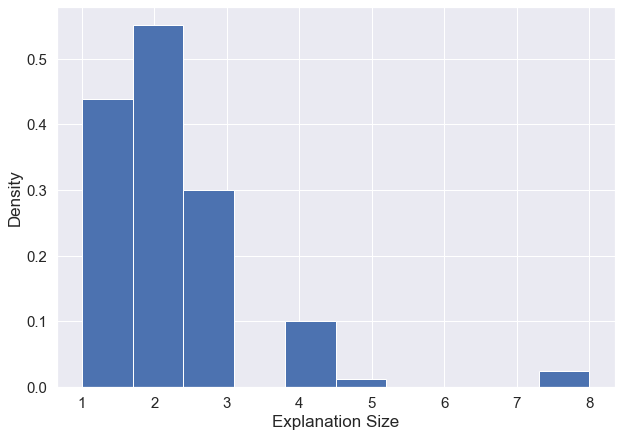

In [27]:
sns.set()

plt.hist(explanation_size_list_mine_syn1, density=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn1.png', dpi=100)
plt.show()

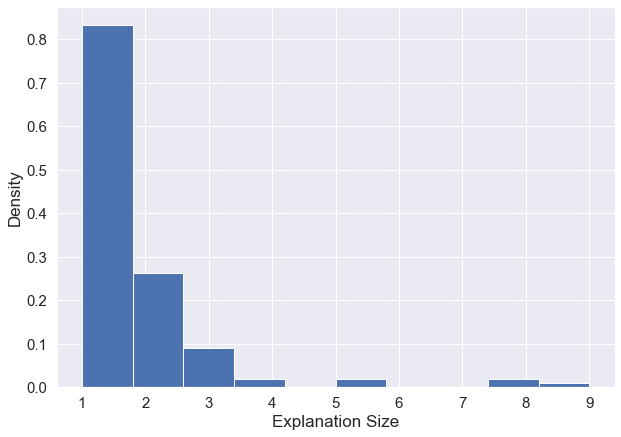

In [24]:
sns.set()

plt.hist(explanation_size_list_mine_syn4,density=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn4.png', dpi=100)
plt.show()

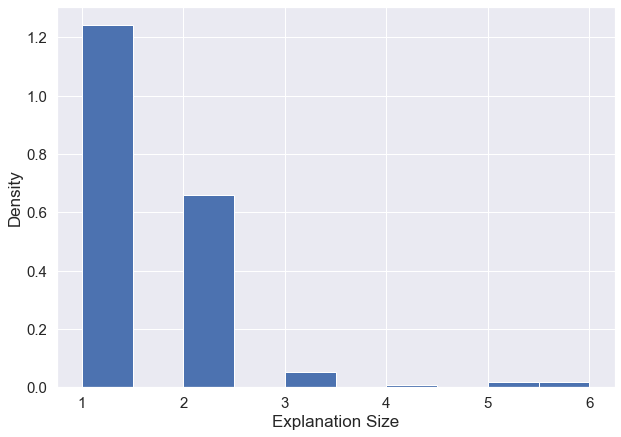

In [25]:
sns.set()

plt.hist(explanation_size_list_mine_syn5, density=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Explanation Size', fontsize=17)
plt.ylabel('Density', fontsize=17)

figure = plt.gcf()
figure.set_size_inches(10, 7)
figure.savefig('plots/explanation_size_syn5.png', dpi=100)
plt.show()